In [1]:
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib import pyplot as plt
from bertopic import BERTopic
from datetime import datetime

C:\Users\marit\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import umap
import seaborn as sns
import numpy as np
import pandas as pd

## Lectura del dataset "app_reviews"

In [3]:
review = pd.read_csv('https://raw.githubusercontent.com/LuisSante/Datasets/main/app_reviews.csv')
review = review.drop(['date','star'],axis=1)
#review = pd.read_csv('C:/Users/USUARIO/Documents/Universidad/4A. Inteligencia Artificial/Dataset/app_reviews.csv')
review

,package_name,review
0,com.mantz_it.rfanalyzer,Great app! The new version now works on my Bra...
1,com.mantz_it.rfanalyzer,Great It's not fully optimised and has some is...
2,com.mantz_it.rfanalyzer,Works on a Nexus 6p I'm still messing around w...
3,com.mantz_it.rfanalyzer,The bandwidth seemed to be limited to maximum ...
4,com.mantz_it.rfanalyzer,Works well with my Hackrf Hopefully new update...
...,...,...
288060,com.termux.api,it doesn't do anything after installing this i...
288061,com.termux.api,I like this app . Its is very helpful for use....
288062,com.termux.api,Finally Brings back the Unix command line to A...
288063,com.termux.api,The API feature is great just need loads more...


### Se extrae en un corpus todos los reviews o criticas de usuario

In [4]:
def extract_corpus(dataset):
    print(datetime.today(), "extrayendo oraciones...")
    lista = []  
    for i in range(len(dataset['package_name'].unique())):#iterar entre los package_name unicos
        dataset_temp = dataset.loc[dataset['package_name'] == dataset['package_name'].unique()[i]]
        lista.append({'package_name':dataset['package_name'].unique()[i], 'size': len(dataset_temp)})#otener un package_name y el número de oraciones

    lista = sorted(lista, key=lambda x: x['size'], reverse=True)#se ordena para saber que package_name tiene el mayor n° de oraciones
    dataframe = dataset[dataset['package_name'] == lista[1]['package_name']]#el mayor será el elemnto que ocupa la posicion 0
    corpus = list(dataframe['review'])#extraemos un corpus
    
    #corpus = clean_corpus(corpus)

    return corpus

### Convertir datos en un Dataframe a un manejo más ágil

In [5]:
def convert_corpus_to_dataFrame(corpus):
    print(datetime.today(), "Convirtiendo las oraciones extraidas a un dataframe...")
    corpus_ds = {
        'Sentences' : corpus
    }

    dataset_new = pd.DataFrame(corpus_ds)
    return dataset_new

In [6]:
def convert_embbedings_to_dataFrame(embeddings):
    print(datetime.today(), "Convirtiendo las incrustaciones a un dataframe...")
    array = []
    for i in embeddings:
        array.append([i])

    dataset_new = pd.DataFrame(array, columns=['Embeddings'])
    return dataset_new

### Se crea una función que nos permita incrustar las oraciones, para esto usamos un modelo pre-entrenado de SBERT

In [7]:
def neural_embeddings(dataset):
    model_embedder = SentenceTransformer('all-MiniLM-L6-v2')#modelo pre-entrenado
    corpus = extract_corpus(dataset)#extraemos un corpus del dataset 
    print(datetime.today(), "Incrustando las oraciones...")
    embeddings = model_embedder.encode(corpus, 
                                        convert_to_tensor=False, 
                                        show_progress_bar=True) #generamos las incrustaciones 

    embeddings = embeddings /  np.linalg.norm(embeddings, axis=1, keepdims=True) #normalizamos

    return embeddings, corpus

In [8]:
def neural_embeddings_queries(queries):
    model_embedder = SentenceTransformer('all-MiniLM-L6-v2')#modelo pre-entrenado

    embeddings_queries = model_embedder.encode(queries, 
                                        convert_to_tensor=False) #generamos las incrustaciones 

    embeddings_queries = embeddings_queries /  np.linalg.norm(embeddings_queries, axis=0, keepdims=True) #normalizamos

    return embeddings_queries

### Para obtener el "mejor" cluster aplicamos el método de la silueta

In [9]:
#en esta funcion hace la tarea de obtener el mejor k con agglomerative clustering
def silhoutte(dataset, attempts):
    embeddings, corpus = neural_embeddings(dataset)
    print(datetime.today(), "Calculando el mejor k...")
    scores_silhouette = [] #guardaremos todos los resultados del método de la silueta para devolver el mayor

    for k in range(2,attempts+1):
        agglomerative_clusterering = AgglomerativeClustering(n_clusters=k, 
                                                            affinity="cosine" , 
                                                            linkage="complete").fit(embeddings)
                                                            
        cluster_labels = agglomerative_clusterering.labels_

        silhouette_avg = silhouette_score(embeddings, cluster_labels)
        scores_silhouette.append(silhouette_avg)

    max_score = max(scores_silhouette)
    max_index = scores_silhouette.index(max_score)
    n_clusters = max_index + 2

    return n_clusters, embeddings, corpus

### Al tener el "mejor" número de clusters, se procede a segmentar las oraciones

In [10]:
def topics_segmentation(dataset_review, attempts):
    n_clusters, embeddings, corpus = silhoutte(dataset_review, attempts) # se le pasa el mejor K

    agglomerative_clusterering = AgglomerativeClustering(n_clusters=n_clusters, 
                                                        affinity="cosine", 
                                                        linkage="complete").fit(embeddings)
                                                        
    cluster_labels = agglomerative_clusterering.labels_ #obtengo las etiquetas respectivas a las oraciones

    model_topics = BERTopic(nr_topics = n_clusters, language='english') # entreno para sacar K temas 
    topics, prob = model_topics.fit_transform(corpus)

    label_topics = model_topics.generate_topic_labels(nr_words=8, topic_prefix=False) # temas
    
    #hierarchical_topics = model_topics.hierarchical_topics(corpus,topics)

    #print(hierarchical_topics)
    #print(label_topics)

    label_topics.pop(0) #elimino el grupo de temas atípicos

    return cluster_labels, label_topics, embeddings, corpus

### A cada oración le asignamos el cluster al que pertenece

In [11]:
def clustering(dataset_review, attempts):
    cluster_labels, label_topics, embeddings, corpus = topics_segmentation(dataset_review, attempts)
    print(datetime.today(), "Asignando un cluster a cada oración...")
    corpus_dataframe = convert_corpus_to_dataFrame(corpus) #de set de oraciones se convierte en un DF para asignarle su número de cluster
    corpus_dataframe['cluster'] = cluster_labels #se le asigna a cada oración un cluster

    return embeddings, label_topics, corpus_dataframe

### Búsqueda semántica para encontrar el tema de cada cluster

In [12]:
def semantic_search(dataset_review, attemps):
    embeddings, label_topics, corpus_dataframe = clustering(dataset_review, attemps) #tomo embeddings para no volver a hacer el mismo trabajo 2 veces
    dataframe_embeddings = convert_embbedings_to_dataFrame(embeddings) #convierto a cada lista de embeddings en un DF para evaluar con cada tema
    dataframe_embeddings['cluster'] = corpus_dataframe['cluster'] # le asigno los clusters
    sort_embeddings =  dataframe_embeddings.sort_values(by=['cluster']) 
    sort_embeddings = sort_embeddings.reset_index(drop=True)
    nr_clusters = sort_embeddings['cluster'].unique() # extrae las un representante de cada cluster

    first_sentences = [] #se almacenara cada primera oracion incrustada de cada cluster para asignarle un topic
    j = 0
    i = 0
    while i < len(sort_embeddings):               
        if(j < len(nr_clusters) and sort_embeddings['cluster'][i] == nr_clusters[j]):
            first_sentences.append(sort_embeddings['Embeddings'][i]) #almacena
            j+=1
        i+=1

    queries = label_topics #queries seran los temas
    topics = [] 
    in_clusters = [] #se almacena los temas y los clusters, para que tengan un mismo índice en común
    print(datetime.today(), "Incrustando los temas...")
    for topic in queries:

        embeddings_queries = neural_embeddings_queries(topic) #incrusta los temas 
        cos_scores = util.cos_sim(embeddings_queries, first_sentences)[0] #se saca la similaridad de cada tema con respecto a las demas oraciones

        cos_scores_numpy = cos_scores.numpy() #se convierte a tensor a numpu
        cos_scores_list = cos_scores_numpy.tolist() #se convierte de numpy a list
        max_coincidence = max(cos_scores_list)
        cluster = cos_scores_list.index(max_coincidence)

        if(len(topics) == 0): 
            topics.append(topic)
            in_clusters.append(cluster)

        elif(topic not in topics and cluster not in in_clusters): #para que no repite un tema con un cluster y viceversa
            topics.append(topic)
            in_clusters.append(cluster)
    tupla = [] ##tamaño k -> k es el tamaño de cluster
    for i in range(len(topics)):
        tupla.append({'Topics': topics[i] , 'Cluster': in_clusters[i]}) #empareja    

    return embeddings, tupla, corpus_dataframe
        

### Para dar visualización de estas oraciones en un plano euclidiano, aplicamos una técnica de reducción de dimensiones 

In [13]:
def dimension_reduction(embeddings):
    print(datetime.today(), "Reduciendo la dimensión de las incrustaciones...")
    scaler = umap.UMAP(n_components=2).fit_transform(embeddings)
    dimension_2d = pd.DataFrame(scaler, columns=['x', 'y'])
    return dimension_2d

### Mostraremos un gráfico de la segmentación de oraciones y un DataFrame de las oraciones con su respectivo cluster 

In [14]:
def show_graphics_and_themes(dataset_review, attemps):
    embeddings, reporte_tuplas, corpus_dataframe = semantic_search(dataset_review, attemps)
    review_2d = dimension_reduction(embeddings) #se reduce a dos dimensiones las incrustaciones para poder plotear
    review_2d['labels'] = corpus_dataframe['cluster']
    
    print(datetime.today(), "Ploteando y obteniendo temas...")

    reporte_tuplas = pd.DataFrame(reporte_tuplas, columns=['Topics','Cluster'])
    reporte_tuplas = reporte_tuplas.sort_values(by=['Cluster'])
    reporte_tuplas = reporte_tuplas.reset_index(drop=True)

    assign = [] 
    lista_reporte = list(reporte_tuplas['Cluster'])
    lista_topics = list(corpus_dataframe['cluster'])
    for i in range(len(corpus_dataframe)):
        if(lista_topics[i] in lista_reporte):
            indexs = lista_reporte.index(lista_topics[i])
            assign.append(reporte_tuplas['Topics'][indexs])
        else:
            assign.append("-1")
    
    corpus_dataframe['Topics'] = assign

    plt.figure(figsize=(15, 15))
    clustered = review_2d[review_2d.labels != -1]

    plt.scatter(review_2d.x, 
                review_2d.y, 
                c=clustered.labels, 
                s=20,
                cmap='Spectral')

    plt.colorbar()
    plt.show()
    
    return corpus_dataframe, reporte_tuplas

2022-08-19 16:53:49.311625 extrayendo oraciones...
2022-08-19 16:54:06.760483 Incrustando las oraciones...


Batches: 100%|██████████| 713/713 [02:53<00:00,  4.11it/s]


2022-08-19 16:57:00.291618 Calculando el mejor k...
2022-08-19 20:55:40.150448 Asignando un cluster a cada oración...
2022-08-19 20:55:40.153451 Convirtiendo las oraciones extraidas a un dataframe...
2022-08-19 20:55:40.157453 Convirtiendo las incrustaciones a un dataframe...
2022-08-19 20:55:40.279449 Incrustando los temas...
2022-08-19 20:56:07.738609 Reduciendo la dimensión de las incrustaciones...
2022-08-19 20:56:26.519259 Ploteando y obteniendo temas...


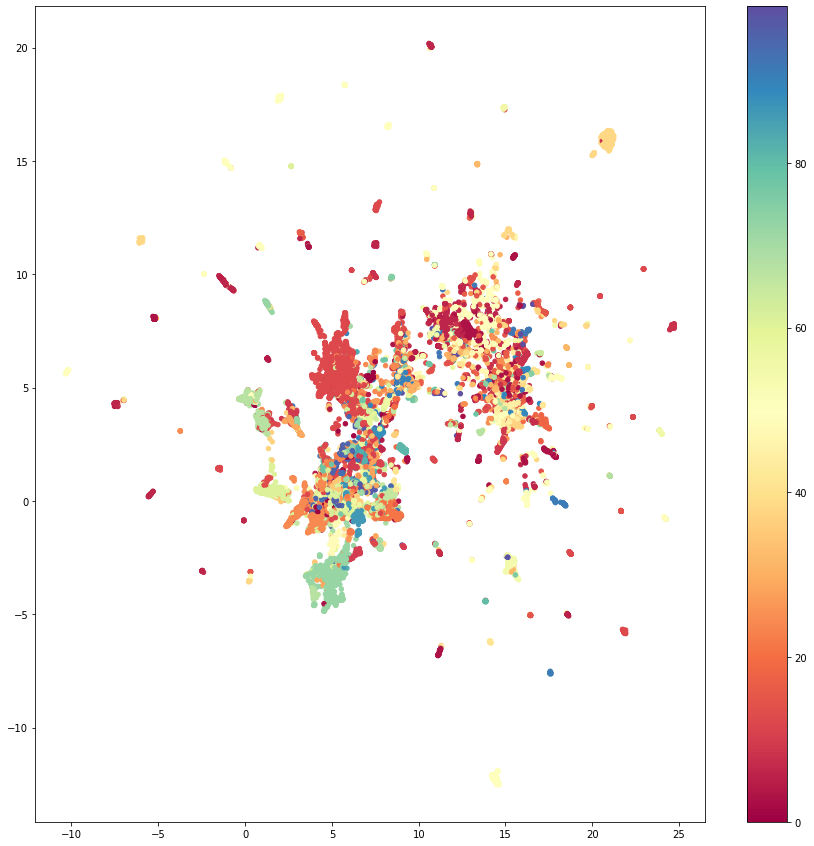

In [15]:
dataframe, reporte_tuplas = show_graphics_and_themes(review, 100)

In [16]:
dataframe

,Sentences,cluster,Topics
0,Awesome app,12,indian_india_app_indians_jai_use_hind_hai
1,Nice,50,-1
2,Rkj Fine,68,-1
3,My Telegram I Love It,72,super_nice_top_app_telegram_very_hi_kathirvijay
4,Its good application i love it.....,24,-1
...,...,...,...
22811,Nice,50,-1
22812,Gud nd nice app never seen,12,indian_india_app_indians_jai_use_hind_hai
22813,I like this app,12,indian_india_app_indians_jai_use_hind_hai
22814,Dunya,51,reza_yeah_you_allah_love_mohammad_yep_anand


In [17]:
reporte_tuplas

,Topics,Cluster
0,best_the_messager_message_its_of_class_far,0
1,best_01052017_eldor_thumb_best1_bestloved_best...,3
2,awesome_nothing_simply_amazing_this_incredible...,6
3,tanks_ali_tele_telgram_teligram_alie_salam_tel,8
4,program_iran_iranian_bahrain_in_software_popul...,9
5,indian_india_app_indians_jai_use_hind_hai,12
6,its_good_quite_haa_overall_pretty_very_event,13
7,supr_nice_sup_suprrrr_very_suprb_sushma_steaker,16
8,love_gd_gh_ggg_gg_mmd_manisha_me,17
9,de_la_que_en_los_non_con_es,18


In [18]:
'''assign = []
lista_reporte = list(reporte['Cluster'])
lista_topics = list(topics['cluster'])
for i in range(len(topics)):
    if(lista_topics[i] in lista_reporte):
        indexs = lista_reporte.index(lista_topics[i])
        assign.append(reporte['Topics'][indexs])
    else:
        assign.append("-1")

topics['Topics'] = assign
topics'''

'assign = []\nlista_reporte = list(reporte[\'Cluster\'])\nlista_topics = list(topics[\'cluster\'])\nfor i in range(len(topics)):\n    if(lista_topics[i] in lista_reporte):\n        indexs = lista_reporte.index(lista_topics[i])\n        assign.append(reporte[\'Topics\'][indexs])\n    else:\n        assign.append("-1")\n\ntopics[\'Topics\'] = assign\ntopics'